Focus on 2 questions: 
* How many ads from candidates were fact checked? 
    * Output charts looking at details by candidates and parties (add party to data)
    * % of ads to be factchecked
    * % of ads aired in time period
    * 
* How do ads change as they air closer to the election date (Nov 8, 2016)
    * Look at ad volume over time
    * Look at ad minutes aired over time
    * Look at these by states to see how many ad strategies might change in different markets

In [148]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns
import datetime as dt

%matplotlib inline 

In [2]:
df = pd.read_csv('data/political_tv_ad_archive_CLEANED.csv')
print(df.shape)
df.head()

(223669, 39)


,id,wp_identifier,network,location,program,program_type,start_time,end_time,archive_id,embed_url,...,market_count,transcript,fact_checked,num_cand,cand_ln,maj_party,winner_name,winner_party,winner_votes_pct,result_change_summary
0,1,5643,KLAS,"Las Vegas, NV",8 News Now at 5 PM,news,2016-09-09 00:12:59+00:00,2016-09-09 00:13:29+00:00,PolAd_HillaryClinton_f1h3j,https://archive.org/embed/PolAd_HillaryClinton...,...,6,IThere's a race going on right approve tnow.me...,0,1,Clinton,D,"CLINTON, HILLARY",DEMOCRAT,0.479178,"DEMOCRAT, MARGIN TIGHTENED"
1,2,5643,WNCN,"Raleigh-Durham-Fayetteville, NC",North Carolina News at 500PM,news,2016-09-06 21:58:25+00:00,2016-09-06 21:58:55+00:00,PolAd_HillaryClinton_f1h3j,https://archive.org/embed/PolAd_HillaryClinton...,...,6,IThere's a race going on right approve tnow.me...,0,1,Clinton,D,"TRUMP, DONALD J.",REPUBLICAN,0.498281,"REPUBLICAN, MARGIN TIGHTENED"
2,3,5643,KLAS,"Las Vegas, NV",Face the Nation,news,2016-09-04 16:24:25+00:00,2016-09-04 16:24:55+00:00,PolAd_HillaryClinton_f1h3j,https://archive.org/embed/PolAd_HillaryClinton...,...,6,IThere's a race going on right approve tnow.me...,0,1,Clinton,D,"CLINTON, HILLARY",DEMOCRAT,0.479178,"DEMOCRAT, MARGIN TIGHTENED"
3,4,5643,WFLA,"Tampa-St. Petersburg, FL",Days of Our Lives,not news,2016-08-30 17:59:20+00:00,2016-08-30 17:59:50+00:00,PolAd_HillaryClinton_f1h3j,https://archive.org/embed/PolAd_HillaryClinton...,...,6,IThere's a race going on right approve tnow.me...,0,1,Clinton,D,"TRUMP, DONALD J.",REPUBLICAN,0.490219,FLIPPED REPUBLICAN
4,5,5643,KSNV,"Las Vegas, NV",The Tonight Show Starring Jimmy Fallon,news,2016-09-06 07:02:22+00:00,2016-09-06 07:02:52+00:00,PolAd_HillaryClinton_f1h3j,https://archive.org/embed/PolAd_HillaryClinton...,...,6,IThere's a race going on right approve tnow.me...,0,1,Clinton,D,"CLINTON, HILLARY",DEMOCRAT,0.479178,"DEMOCRAT, MARGIN TIGHTENED"


In [3]:
ads_metadata = pd.read_csv("data/unique_ad_metadata.csv")
print(ads_metadata.shape)
ads_metadata.head()

(2842, 16)


,wp_identifier,archive_id,embed_url,sponsors,sponsor_types,subjects,candidates,type,race,cycle,message,air_count,reference_count,market_count,transcript,date_ingested
0,8403,PolAd_CatherineCortezMasto_jbah8,https://archive.org/embed/PolAd_CatherineCorte...,Catherine Cortez Masto for Senate,Candidate Committee,"Candidate Biography, Bipartisanship, Criminal ...",Catherine Cortez Masto,campaign,NVS2,2016.0,pro,185,0,1,NaN,2016/11/17 5:03:54 UTC
1,8404,PolAd_DonaldTrump_kc0en,https://archive.org/embed/PolAd_DonaldTrump_kc0en,Hillary for America,Multiple,"Nuclear, Candidate Biography, Military, Foreig...",Donald Trump,campaign,PRES,2016.0,con,139,0,1,NaN,2016/11/17 5:02:52 UTC
2,8358,PolAd_DonaldTrump_ncck5,https://archive.org/embed/PolAd_DonaldTrump_ncck5,Hillary for America,Multiple,"Bankruptcy, Candidate Biography, Workers",Donald Trump,campaign,PRES,2016.0,con,195,0,2,NaN,2016/11/14 10:44:42 UTC
3,8359,PolAd_Guns_gv0de,https://archive.org/embed/PolAd_Guns_gv0de,National Rifle Assn,PAC,Guns,NaN,campaign,NaN,NaN,unknown,87,0,3,NaN,2016/11/14 10:44:15 UTC
4,8361,PolAd_Guns_Veterans_Military_z2bvd,https://archive.org/embed/PolAd_Guns_Veterans_...,National Rifle Assn,PAC,"Guns, Veterans, Military",NaN,campaign,NaN,NaN,unknown,54,0,3,NaN,2016/11/14 10:43:51 UTC


## Unique Ads Fact Checked

In [4]:
num_unique_ads = len(ads_metadata.archive_id.unique())
num_unique_fc_ads = len(ads_metadata[ads_metadata.reference_count > 0].archive_id.unique())

print(num_unique_ads, num_unique_fc_ads)
print(num_unique_fc_ads / num_unique_ads)

2842 120
0.0422237860661506


Looking in the unique ads dataset
* Only 120 of the 2842 unique ads aired during the 2016 election were fact checked
* meaning only 4.2% of all unique ads were fact checked

## How many fact check ads were shown during 2016 Presidential Campaign

In [5]:
df_2016 = df[df.start_time >= '2016-01-01']

In [6]:
df.shape

(223669, 39)

In [7]:
df_2016.shape

(202493, 39)

In [8]:
min(df.end_time), max(df.end_time)

('2015-10-05 10:11:20+00:00', '2016-11-08 23:59:15+00:00')

In [9]:
min(df_2016.end_time), max(df_2016.end_time)

('2016-01-01 00:06:05+00:00', '2016-11-08 23:59:15+00:00')

In [10]:
check = df_2016.groupby('fact_checked').agg({'archive_id':'nunique'}).reset_index()
check['pct_of_total'] = check.archive_id / sum(check.archive_id)
check

,fact_checked,archive_id,pct_of_total
0,0,709,0.90665
1,1,73,0.09335


In [11]:
73/ 782

0.09335038363171355

* Over 782 unique ads aired on the 2016 Presidential election (from end of Jan 2016 to Nov 2016)
* Of these only 73 unique ads shown were fact checked
* ~9.3% of unique ads shown during the 2016 Presidential election were fact checked

In [12]:
## create a time series chart showing volume of ads and # show that were fact checked
df_2016.start_time = df_2016.start_time.apply(lambda x : dt.datetime.strptime(x.split("+")[0], "%Y-%m-%d %H:%M:%S"))
df_2016.end_time = df_2016.end_time.apply(lambda x : dt.datetime.strptime(x.split("+")[0], "%Y-%m-%d %H:%M:%S"))

/var/folders/wh/hvbvgs6x231gx68s1f897rh80000gn/T/ipykernel_52023/1605178573.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_2016.start_time = df_2016.start_time.apply(lambda x : dt.datetime.strptime(x.split("+")[0], "%Y-%m-%d %H:%M:%S"))
/var/folders/wh/hvbvgs6x231gx68s1f897rh80000gn/T/ipykernel_52023/1605178573.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_2016.end_time = df_2016.end_time.apply(lambda x : dt.datetime.strptime(x.split("+")[0], "%Y-%m-%d %H:%M:%S"))
/var/folders/wh/hvbvgs6x23

In [30]:
import warnings 
warnings.filterwarnings('ignore')
# plot out by different timestamps
df_2016['month'] = df_2016.start_time.apply(lambda x : x.month)
df_2016['week'] = df_2016.start_time.apply(lambda x : x.week)
df_2016['day'] = df_2016.start_time.apply(lambda x : x.day)
df_2016['hour'] = df_2016.start_time.apply(lambda x : x.hour)
df_2016['month_day'] = df_2016.month.apply(str) + '-' + df_2016.day.apply(str)

In [31]:
df_2016.week.unique()

array([36, 35, 34, 30, 31,  9,  6, 33, 32, 10, 16, 37, 26, 23, 29,  4, 19,
       22,  1,  8, 15,  3,  5, 27, 53, 13, 28, 25, 24, 11, 18, 14, 21, 20,
        2, 17,  7, 12, 38, 39, 40, 41, 42, 43, 44, 45])

In [80]:
week_df = df_2016.groupby(['week', 'fact_checked']).agg({'archive_id':'count', 'ad_duration_sec':'sum'}).reset_index()
week_df['ad_duration_min'] = week_df.ad_duration_sec / 60
week_df = week_df[week_df['week'] <= 45]
week_df.head()

,week,fact_checked,archive_id,ad_duration_sec,ad_duration_min
0,1,0,5936,185798.0,3096.633333
1,1,1,2457,73671.0,1227.850000
2,2,0,8614,271646.0,4527.433333
3,2,1,2355,70620.0,1177.000000
4,3,0,12641,424859.0,7080.983333


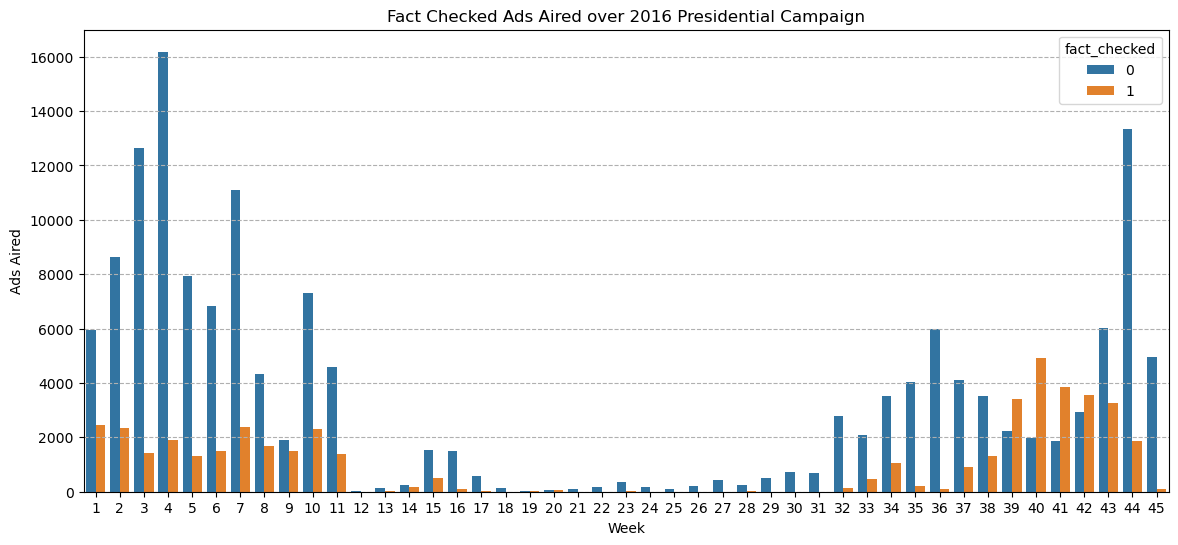

In [81]:
fig, ax = plt.subplots(figsize = (14, 6))

sns.barplot(x = 'week', y = 'archive_id', hue = 'fact_checked', data = week_df, ax=ax)

plt.title('Fact Checked Ads Aired over 2016 Presidential Campaign')
ax.set(xlabel = 'Week', ylabel = 'Ads Aired')
# plt.xticks(rotation = 90)
plt.grid(axis = 'y', linestyle = '--')
plt.show()

* The proportion of non fact checked ads aired is much higher than the proportion of fact checked ads
* Questions the validity of what ads are being aired. 
* It seems more ads were fact checked closer to the election date (Weeks 39 - 44)
    * ads airing closer to the election date may have more influence over the election.
    * Suggesting why more ads aired in this time were fact checked
* We do notice a dip in ads airing during the summer weeks. 
    * https://en.wikipedia.org/wiki/2016_Democratic_Party_presidential_primaries
    * From Wikipedia, each party has a primary election, which starts from Feb 1 to Jun 14 of 2016
    * Thus campaign strategy wise, it seems most parties don't air ads during this period since they are choosing the main party representative. 
    * so all campaigning happens prior and post the primaries. 

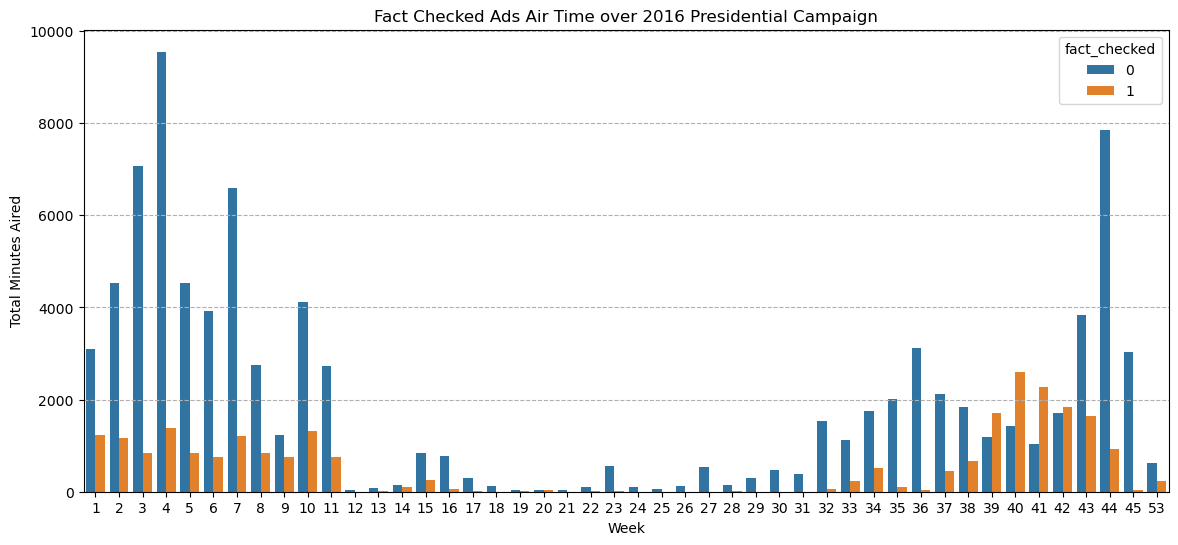

In [59]:
# same ish plot
fig, ax = plt.subplots(figsize = (14, 6))

sns.barplot(x = 'week', y = 'ad_duration_min', hue = 'fact_checked', data = week_df, ax=ax)

plt.title('Fact Checked Ads Air Time over 2016 Presidential Campaign')
ax.set(xlabel = 'Week', ylabel = 'Total Minutes Aired')
# plt.xticks(rotation = 90)
plt.grid(axis = 'y', linestyle = '--')
plt.show()

let's look at fact checked ads post primaries and who they were about

In [218]:
fc = df_2016[df_2016.fact_checked == 1]
# what party the ad was about
fc['ad_party'] = fc.maj_party.apply(lambda x : x if len(x) == 1 else x[1])

In [221]:
df_plot = fc.groupby(['week', 'ad_party']).agg({'archive_id':'count', 'ad_duration_sec':'sum'}).reset_index()
df_plot['ad_duration_min'] = df_plot.ad_duration_sec / 60
df_plot = df_plot[(df_plot['week'] >= 24) & (df_plot['week'] <= 45)]
df_plot.head()

,week,ad_party,archive_id,ad_duration_sec,ad_duration_min
43,24,R,4,120.0,2.0
44,25,R,6,180.0,3.0
45,26,R,1,30.0,0.5
46,28,D,4,120.0,2.0
47,28,R,6,264.0,4.4


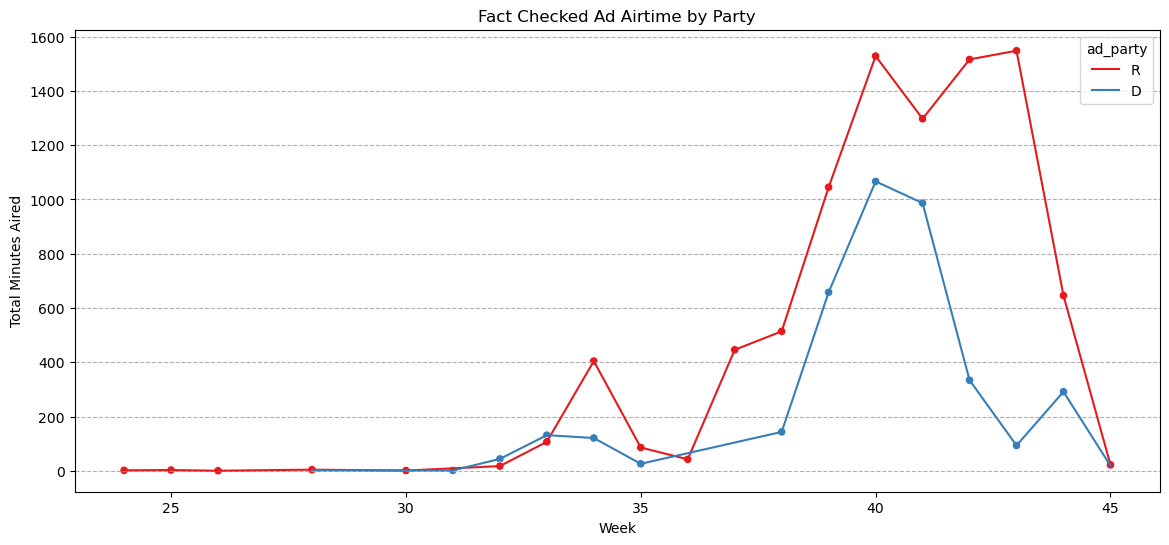

In [225]:
fig, ax = plt.subplots(figsize = (14, 6))

sns.lineplot(x = 'week', y = 'ad_duration_min', hue = 'ad_party', data = df_plot, ax=ax, palette = 'Set1')
sns.scatterplot(x = 'week', y = 'ad_duration_min', hue = 'ad_party', data = df_plot, ax=ax, palette = 'Set1', legend=False)

plt.title('Fact Checked Ad Airtime by Party')
ax.set(xlabel = 'Week', ylabel = 'Total Minutes Aired')
# plt.xticks(rotation = 90)
plt.grid(axis = 'y', linestyle = '--')
plt.show()

More Republican Ads were fact checked towards the election date. 
* We see this trend where more Republican ads were fact checked around week 33 and 34. 
* As we get closer to the election, more ads were fact checked. 

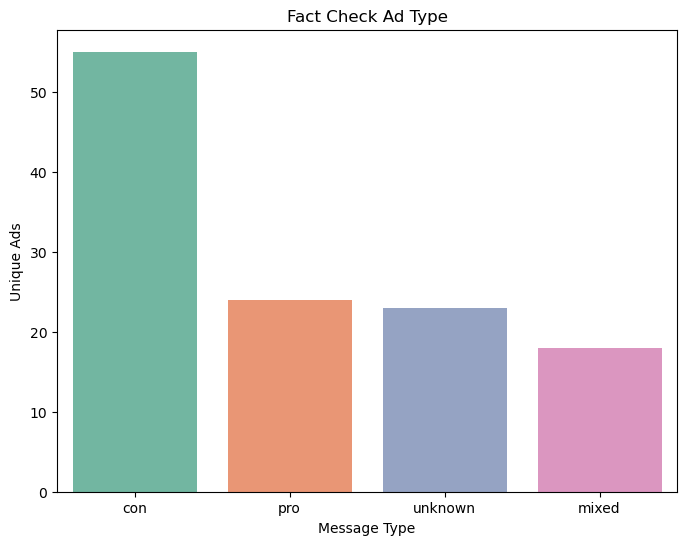

In [246]:
fig, ax = plt.subplots(figsize = (8, 6))

plot = ads_metadata[ads_metadata.reference_count > 0].message.value_counts().reset_index()
sns.barplot(x='index', y='message', data = plot, ax=ax, palette = 'Set2')

plt.title('Fact Check Ad Type')
ax.set(xlabel = 'Message Type', ylabel = 'Unique Ads')
# plt.xticks(rotation = 90)
# plt.grid(axis = 'y', linestyle = '--')
plt.show()

majority of ads checked are negatively connotation ads

## Investigating how ads change closer to the election date

* let's look at trump and hillary sponsored ads as they were the main candidates post primraries
    * compare prior to primaries and post primaries
* check message type
* check fcat checks

In [67]:
# filter for only clinton and trump
ads_tc = df_2016[(df_2016.sponsor_summary == 'Clinton') | (df_2016.sponsor_summary == 'Trump')]

### Comparing Trump vs Clinton

In [72]:
# clinton definitely showed more ads than trump
ads_tc.sponsor_summary.value_counts()

Clinton    77846
Trump      42757
Name: sponsor_summary, dtype: int64

In [82]:
df_plot1 = ads_tc.groupby(['week', 'sponsor_summary']).agg({'archive_id':'count'}).reset_index()
df_plot1 = df_plot1[df_plot1.week <= 45]
df_plot1.head()

,week,sponsor_summary,archive_id
0,1,Clinton,1466
1,1,Trump,1129
2,2,Clinton,1902
3,2,Trump,1072
4,3,Clinton,3075


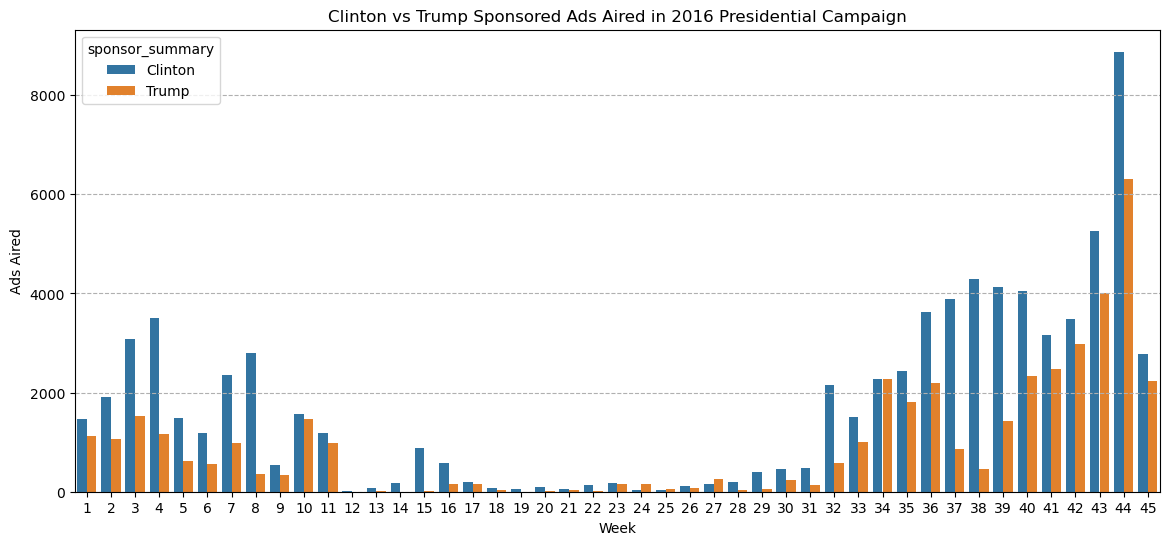

In [84]:
fig, ax = plt.subplots(figsize = (14, 6))

sns.barplot(x = 'week', y = 'archive_id', hue = 'sponsor_summary', data = df_plot1, ax=ax)

plt.title('Clinton vs Trump Sponsored Ads Aired in 2016 Presidential Campaign')
ax.set(xlabel = 'Week', ylabel = 'Ads Aired')
# plt.xticks(rotation = 90)
plt.grid(axis = 'y', linestyle = '--')
plt.show()

* Looking early in the year before the primaries
    * Clinton sponsored ads aired more than Trump sponsored ads. 
* Post primaries, we see Clinton kick start a strong ad campaign consistently week over week leading up to the election date.
    * Clinton sponsored ads doubled closer to the election
* Trump sponsored ads aired much less in volume than Clinton's. 
    * Did follow a similar pattern where ad volume ramps up closer to election week

### how do ads differ by State they are displayed in 
* Looking at post primaries data

In [190]:
# battle ground states in primaries
bg_states = ['AZ', 'CO', 'IA', 'WI', 'NH', 'NV', 'NC', 'FL', 'OH', 'PA']

In [201]:
df_plot = ads_tc[ads_tc.state != 'None']
df_plot = df_plot.groupby(['week', 'state', 'sponsor_summary', 'winner_party']).agg({'archive_id':'count', 'ad_duration_sec':'sum'}).reset_index()
df_plot['ad_duration_min'] = df_plot.ad_duration_sec / 60
df_plot = df_plot[(df_plot.week >= 24) & (df_plot.week <= 45)]
df_plot.head()

,week,state,sponsor_summary,winner_party,archive_id,ad_duration_sec,ad_duration_min
236,24,CA,Clinton,DEMOCRAT,24,1027.0,17.116667
237,24,CA,Trump,DEMOCRAT,151,4530.0,75.500000
238,24,MD,Clinton,DEMOCRAT,1,30.0,0.500000
239,24,PA,Clinton,REPUBLICAN,1,30.0,0.500000
240,25,CA,Clinton,DEMOCRAT,24,1946.0,32.433333


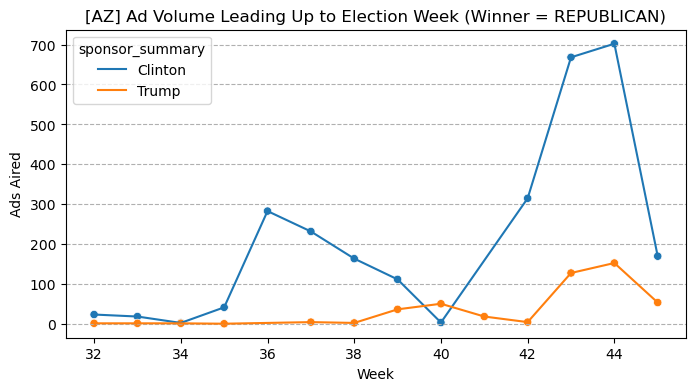

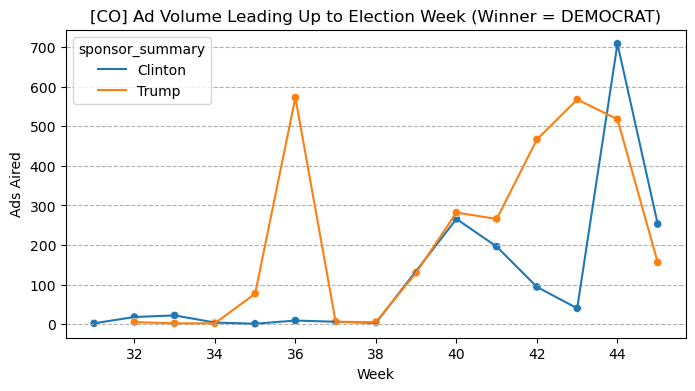

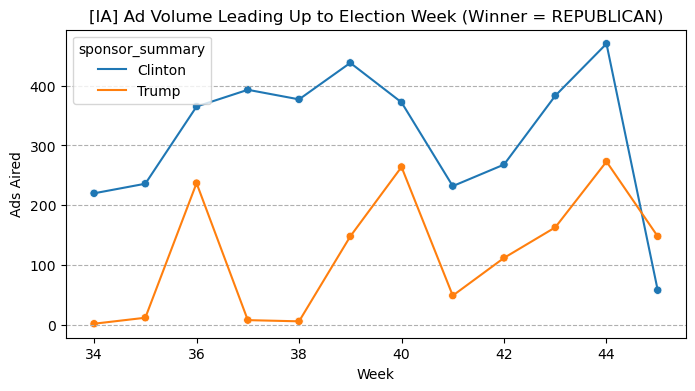

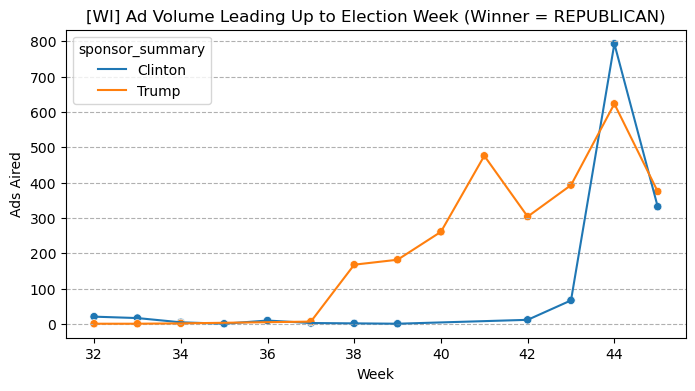

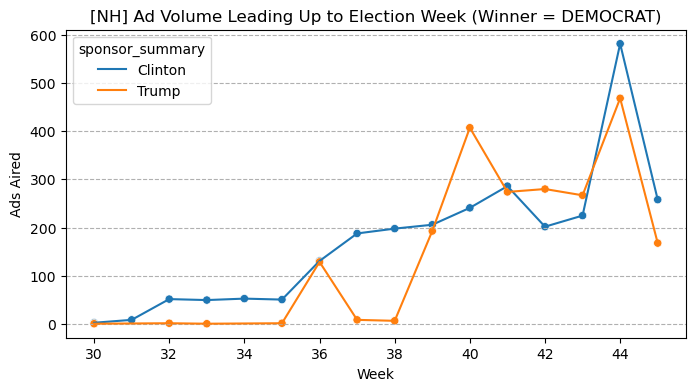

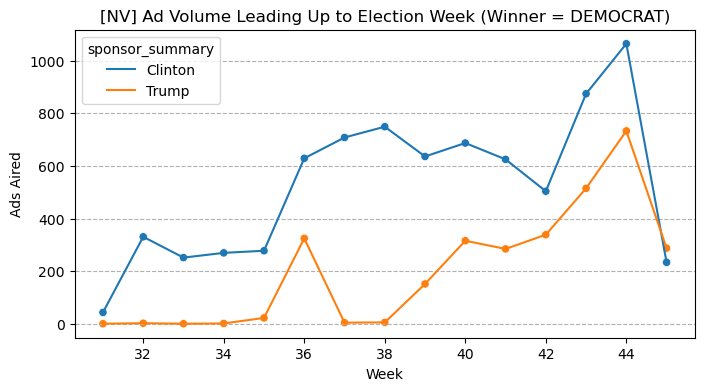

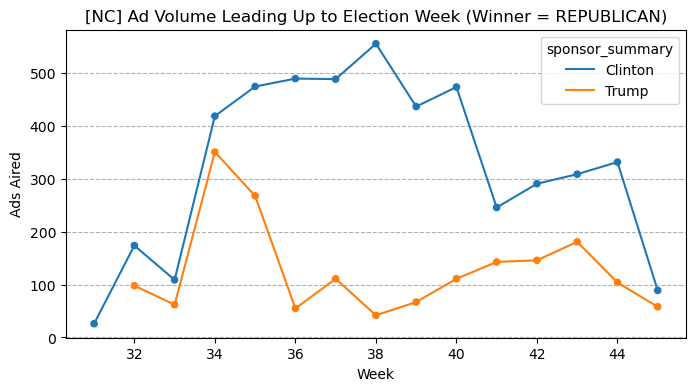

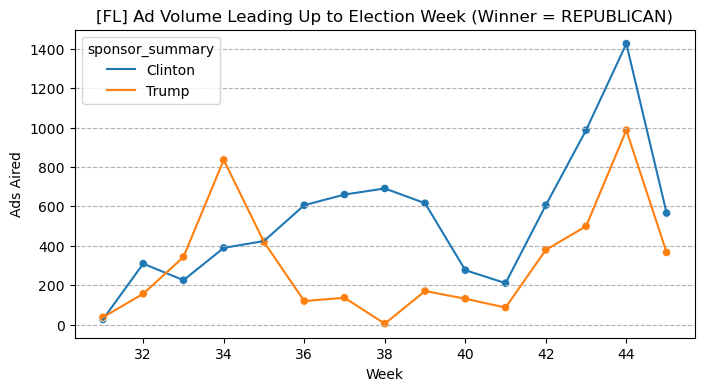

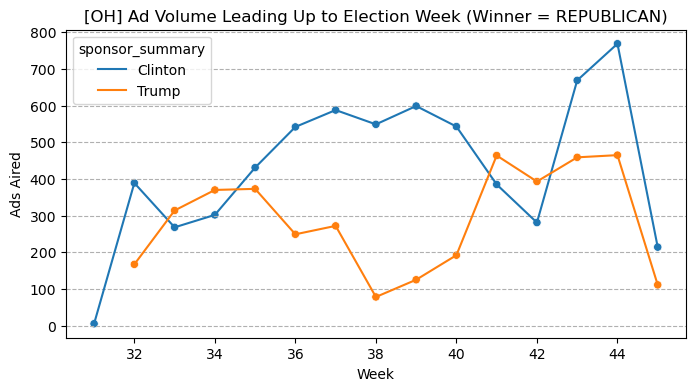

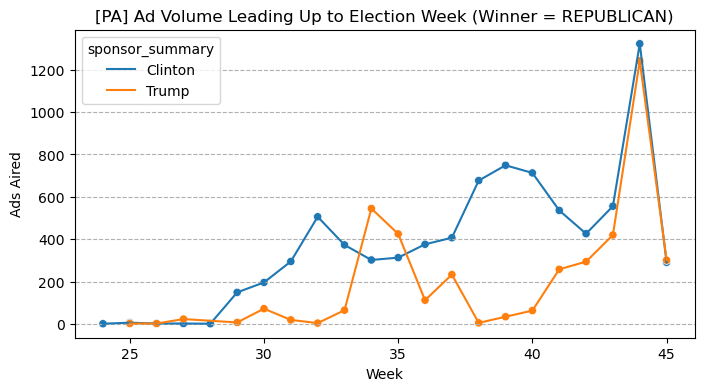

In [209]:
for st in bg_states: 
    df_to_plot = df_plot[df_plot.state == st]
    fig, ax = plt.subplots(figsize = (8, 4))

    sns.lineplot(x = 'week', y = 'archive_id', hue = 'sponsor_summary', data = df_to_plot, ax=ax)
    sns.scatterplot(x = 'week', y = 'archive_id', hue = 'sponsor_summary', data = df_to_plot, ax=ax, legend = False)

    plt.title(f'[{st}] Ad Volume Leading Up to Election Week (Winner = {df_to_plot.winner_party.iloc[0]})')
    ax.set(xlabel = 'Week', ylabel = 'Ads Aired')
    # plt.xticks(rotation = 90)
    plt.grid(axis = 'y', linestyle = '--')
    plt.show()

Candidate sponsored ads change tactics depending on the battleground state
* Competitive Battle Ground states: PA, FL, IA, OH, NC
    * We see in these states that Trump and Clinton compete highly in terms of ad volumes to win over votes
* For other states we see that candidates may output less ads
    * This may be due to a clear victory a candidate might see for themselves or the opponent
    * Clinton outputed less ads in following states: WI (R), CO (D)
        * Clinton barely put any ads in WI till the end towards the election day and loss the state. 
    * Trump outputed less ads in following states: AZ (R), NV (D), NH (D)
* Interesting how each candidate may have several spikes in ad volume or consistent output of ads leading up to the election 
    * For competitive battle ground states, we see an consistent output of ads 
    * for non competitive battle ground states, we see more spikes closer to the election date and 1 or 2 other spikes leading up
    * Suggests that some states don't require much advertising 

* look at proportion of ads messaging by what candidate they were about
* Look at propoortion of ads by time aired
* look at proportion of ads messaging by what sponsor they were

In [97]:
df_plot2 = ads_tc.groupby(['week', 'message']).agg({'archive_id':'count'}).reset_index()
df_plot2 = df_plot2[df_plot2.week <= 45]
df_plot2_1 = df_plot2.pivot(index = 'week', columns = 'message', values = 'archive_id').fillna(0).reset_index()
df_plot2_1.head()

message,week,con,mixed,pro,unknown
0,1,12.0,121.0,1526.0,936.0
1,2,7.0,762.0,1724.0,481.0
2,3,26.0,439.0,3647.0,481.0
3,4,7.0,853.0,3471.0,338.0
4,5,16.0,349.0,1633.0,106.0


In [153]:
values = df_plot2_1[['con', 'mixed', 'pro', 'unknown']]

# add values for bar charts
totals = values.sum(axis=1)
values['totals'] = totals
values['pct_con'] = (values.con / values.totals) * 100
values['pct_mixed'] = (values.mixed / values.totals) * 100
values['pct_pro'] = (values.pro / values.totals) * 100
values['pct_unknown'] = (values.unknown / values.totals) * 100
values['bar4'] = values.pct_unknown # unknown
values['bar3'] = values.pct_mixed + values.bar4 # mixed
values['bar2'] = values.pct_con + values.bar3 # con
values['bar1'] = 100 # pro
# values.head()

In [152]:
df_plot2_1['bar1'] = values.bar1
df_plot2_1['bar2'] = values.bar2
df_plot2_1['bar3'] = values.bar3
df_plot2_1['bar4'] = values.bar4
df_plot2_1.head()

message,week,con,mixed,pro,unknown,bar1,bar2,bar3,bar4
0,1,12.0,121.0,1526.0,936.0,100,41.194605,40.732177,36.069364
1,2,7.0,762.0,1724.0,481.0,100,42.030935,41.795562,16.173504
2,3,26.0,439.0,3647.0,481.0,100,20.596560,20.030481,10.472458
3,4,7.0,853.0,3471.0,338.0,100,25.658599,25.508674,7.239238
4,5,16.0,349.0,1633.0,106.0,100,22.385932,21.625475,5.038023


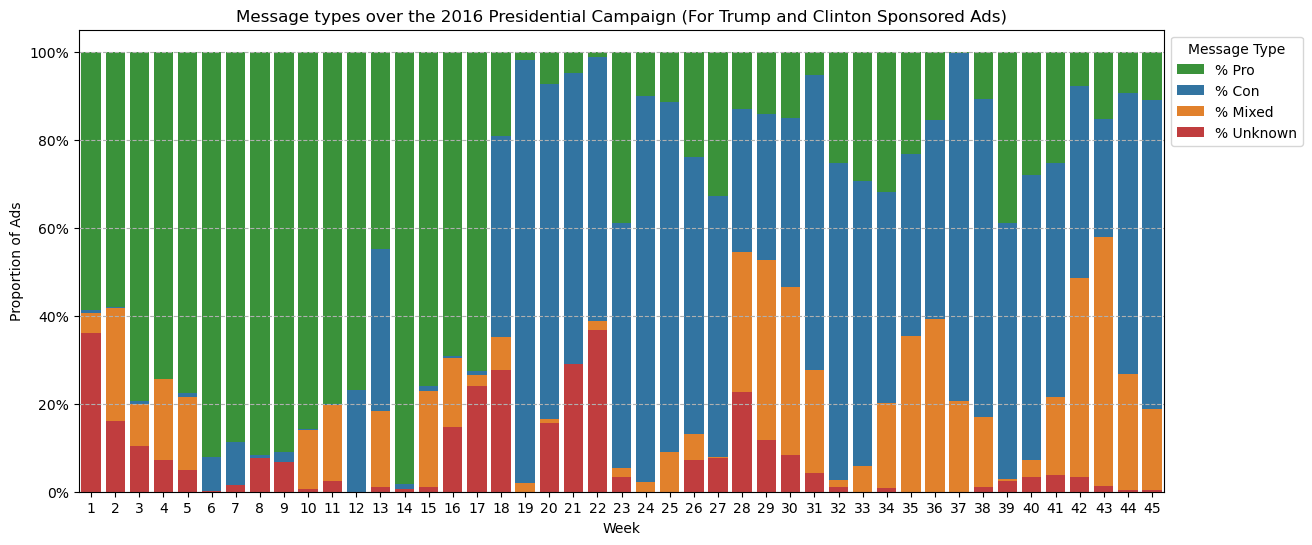

In [154]:
fig, ax = plt.subplots(figsize = (14, 6))

bar1 = sns.barplot(x = 'week', y = 'bar1', data = df_plot2_1, ax=ax, color='tab:green', label = '% Pro')
bar2 = sns.barplot(x = 'week', y = 'bar2', data = df_plot2_1, ax=ax, color='tab:blue', label = '% Con')
bar3 = sns.barplot(x = 'week', y = 'bar3', data = df_plot2_1, ax=ax, color='tab:orange', label = '% Mixed')
bar4 = sns.barplot(x = 'week', y = 'bar4', data = df_plot2_1, ax=ax, color='tab:red', label = '% Unknown')

plt.title('Message types over the 2016 Presidential Campaign (For Trump and Clinton Sponsored Ads)')
plt.legend(title = 'Message Type', bbox_to_anchor = (1., 1))
ax.set(xlabel = 'Week', ylabel = 'Proportion of Ads')
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter())
# plt.xticks(rotation = 90)
plt.grid(axis = 'y', linestyle = '--')
plt.show()

Week 24 is the end of the primaries where candidates are picked for each party. 
* We can see instantly that ads before the primaries differ greatly than ads post the primaries. 
* There is a higher % of negative ad messages showing post the primaries. 
* A large amount of ads also have mixed messaging as well. 

## how many Clinton ads had X messaging

In [159]:
df_plot3 = ads_tc[ads_tc.clinton_sponsored].groupby(['week', 'message']).agg({'archive_id':'count'}).reset_index()
df_plot3 = df_plot3[(df_plot3.week >= 24) & (df_plot3.week <= 45)]
df_plot3_1 = df_plot3.pivot(index = 'week', columns = 'message', values = 'archive_id').fillna(0).reset_index()
df_plot3_1.head()

message,week,con,mixed,pro,unknown
0,24,5.0,4.0,17.0,0.0
1,25,22.0,6.0,5.0,0.0
2,26,60.0,0.0,47.0,14.0
3,27,50.0,1.0,70.0,32.0
4,28,65.0,71.0,12.0,51.0


In [160]:
values = df_plot3_1[['con', 'mixed', 'pro', 'unknown']]

# add values for bar charts
totals = values.sum(axis=1)
values['totals'] = totals
values['pct_con'] = (values.con / values.totals) * 100
values['pct_mixed'] = (values.mixed / values.totals) * 100
values['pct_pro'] = (values.pro / values.totals) * 100
values['pct_unknown'] = (values.unknown / values.totals) * 100
values['bar4'] = values.pct_unknown # unknown
values['bar3'] = values.pct_mixed + values.bar4 # mixed
values['bar2'] = values.pct_con + values.bar3 # con
values['bar1'] = 100 # pro
# values.head()

In [161]:
df_plot3_1['bar1'] = values.bar1
df_plot3_1['bar2'] = values.bar2
df_plot3_1['bar3'] = values.bar3
df_plot3_1['bar4'] = values.bar4
df_plot3_1.head()

message,week,con,mixed,pro,unknown,bar1,bar2,bar3,bar4
0,24,5.0,4.0,17.0,0.0,100,34.615385,15.384615,0.000000
1,25,22.0,6.0,5.0,0.0,100,84.848485,18.181818,0.000000
2,26,60.0,0.0,47.0,14.0,100,61.157025,11.570248,11.570248
3,27,50.0,1.0,70.0,32.0,100,54.248366,21.568627,20.915033
4,28,65.0,71.0,12.0,51.0,100,93.969849,61.306533,25.628141


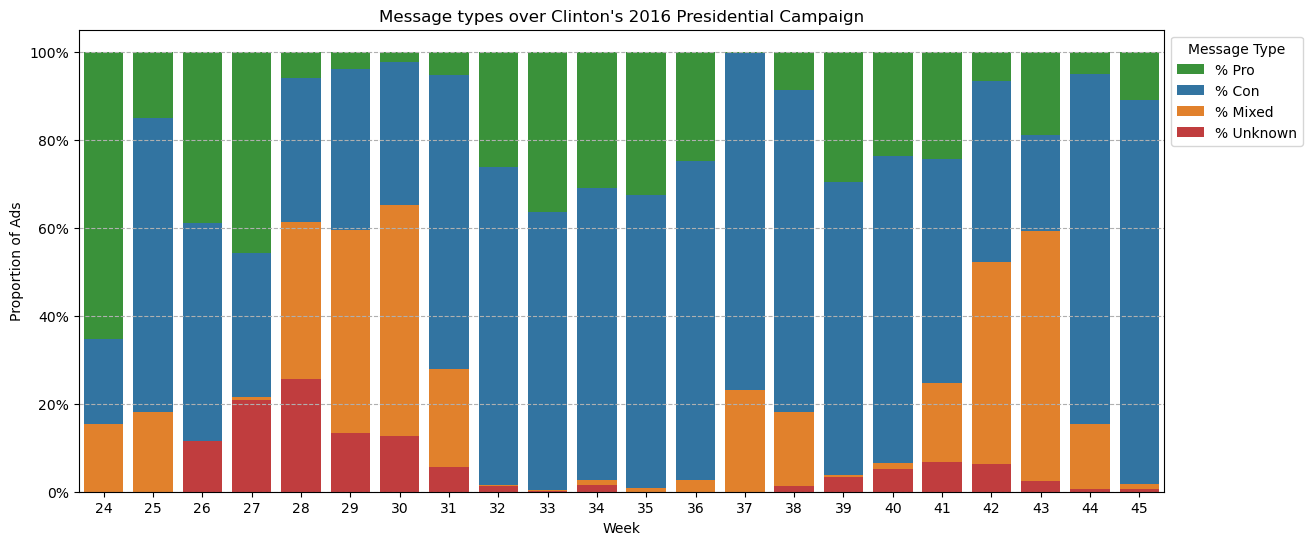

In [162]:
fig, ax = plt.subplots(figsize = (14, 6))

bar1 = sns.barplot(x = 'week', y = 'bar1', data = df_plot3_1, ax=ax, color='tab:green', label = '% Pro')
bar2 = sns.barplot(x = 'week', y = 'bar2', data = df_plot3_1, ax=ax, color='tab:blue', label = '% Con')
bar3 = sns.barplot(x = 'week', y = 'bar3', data = df_plot3_1, ax=ax, color='tab:orange', label = '% Mixed')
bar4 = sns.barplot(x = 'week', y = 'bar4', data = df_plot3_1, ax=ax, color='tab:red', label = '% Unknown')

plt.title("Message types over Clinton's 2016 Presidential Campaign")
plt.legend(title = 'Message Type', bbox_to_anchor = (1., 1))
ax.set(xlabel = 'Week', ylabel = 'Proportion of Ads')
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter())
# plt.xticks(rotation = 90)
plt.grid(axis = 'y', linestyle = '--')
plt.show()

## how many Trump ads had X messaging

In [175]:
df_plot4 = ads_tc[ads_tc.trump_sponsored].groupby(['week', 'message']).agg({'archive_id':'count'}).reset_index()
df_plot4 = df_plot4[(df_plot4.week >= 24) & (df_plot4.week <= 45)]
df_plot4_1 = df_plot4.pivot(index = 'week', columns = 'message', values = 'archive_id').fillna(0).reset_index()
df_plot4_1.head()

message,week,con,mixed,pro
0,24,150.0,0.0,1.0
1,25,48.0,2.0,5.0
2,26,64.0,12.0,0.0
3,27,197.0,0.0,66.0
4,28,8.0,0.0,17.0


In [176]:
values = df_plot4_1[['con', 'mixed', 'pro']]

# add values for bar charts
totals = values.sum(axis=1)
values['totals'] = totals
values['pct_con'] = (values.con / values.totals) * 100
values['pct_mixed'] = (values.mixed / values.totals) * 100
values['pct_pro'] = (values.pro / values.totals) * 100
# values['pct_unknown'] = (values.unknown / values.totals) * 100
# values['bar4'] = values.pct_unknown # unknown
values['bar3'] = values.pct_mixed # mixed
values['bar2'] = values.pct_con + values.bar3 # con
values['bar1'] = 100 # pro
# values.head()

In [177]:
df_plot4_1['bar1'] = values.bar1
df_plot4_1['bar2'] = values.bar2
df_plot4_1['bar3'] = values.bar3
# df_plot3_1['bar4'] = values.bar4
df_plot4_1.head()

message,week,con,mixed,pro,bar1,bar2,bar3
0,24,150.0,0.0,1.0,100,99.337748,0.000000
1,25,48.0,2.0,5.0,100,90.909091,3.636364
2,26,64.0,12.0,0.0,100,100.000000,15.789474
3,27,197.0,0.0,66.0,100,74.904943,0.000000
4,28,8.0,0.0,17.0,100,32.000000,0.000000


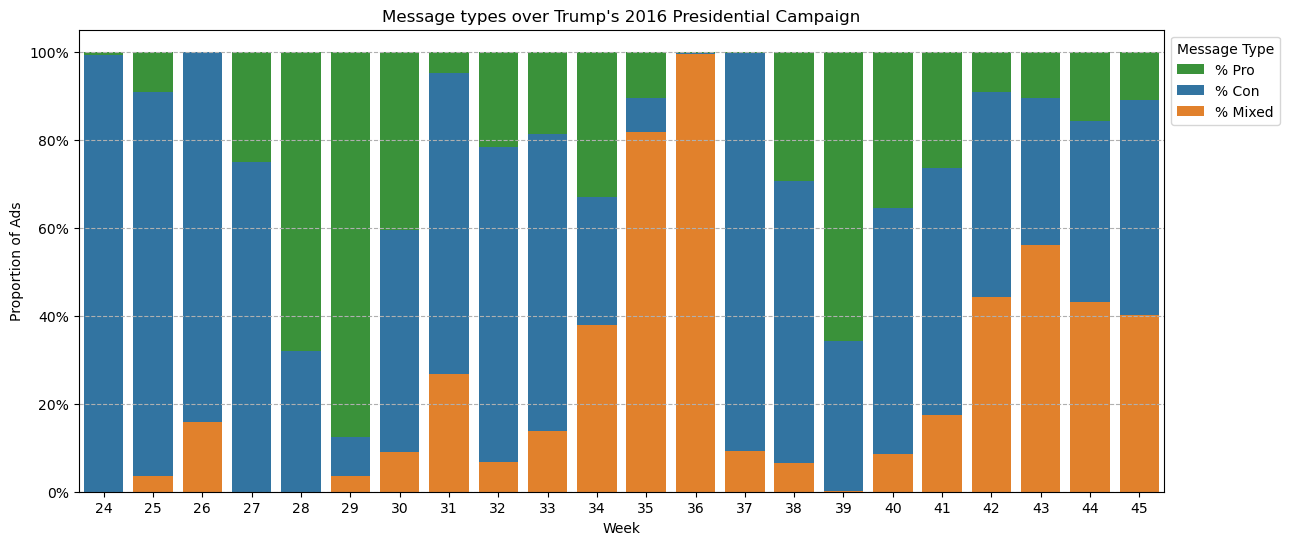

In [179]:
fig, ax = plt.subplots(figsize = (14, 6))

bar1 = sns.barplot(x = 'week', y = 'bar1', data = df_plot4_1, ax=ax, color='tab:green', label = '% Pro')
bar2 = sns.barplot(x = 'week', y = 'bar2', data = df_plot4_1, ax=ax, color='tab:blue', label = '% Con')
bar3 = sns.barplot(x = 'week', y = 'bar3', data = df_plot4_1, ax=ax, color='tab:orange', label = '% Mixed')
# bar4 = sns.barplot(x = 'week', y = 'bar4', data = df_plot3_1, ax=ax, color='tab:red', label = '% Unknown')

plt.title("Message types over Trump's 2016 Presidential Campaign")
plt.legend(title = 'Message Type', bbox_to_anchor = (1., 1))
ax.set(xlabel = 'Week', ylabel = 'Proportion of Ads')
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter())
# plt.xticks(rotation = 90)
plt.grid(axis = 'y', linestyle = '--')
plt.show()

During the primaries
* Majority of ads shown by Clinton seem to be negative related
* Trump also seems to have a majoirty of negative related ads, but has a higher % of pro ads for week 28, 29, 39
    * also seems to have a higher % of mixed messaged ads by Trump sponsors
* most ads are negative so ad strategy seems geared towards negativity

In [248]:
ads_tc['ad_party'] = ads_tc.maj_party.apply(lambda x : x if len(x) == 1 else x[1])

### Clinton messaging type

In [265]:
df_plot3 = ads_tc[ads_tc.clinton_sponsored].groupby(['week', 'ad_party', 'message']).agg({'archive_id':'count'}).reset_index()
df_plot3 = df_plot3[(df_plot3.week >= 24) & (df_plot3.week <= 45)]
df_plot3 = df_plot3[(df_plot3.message == 'pro') | (df_plot3.message == 'con')]
df_plot3['party_mes'] = "[" + df_plot3.ad_party + "] " + df_plot3.message
df_plot3 = df_plot3[df_plot3.party_mes != '[R] pro']

In [266]:
df_plot3.head()

,week,ad_party,message,archive_id,party_mes
76,24,D,pro,17,[D] pro
77,24,R,con,5,[R] con
79,25,D,pro,5,[D] pro
80,25,R,con,22,[R] con
82,26,D,pro,47,[D] pro


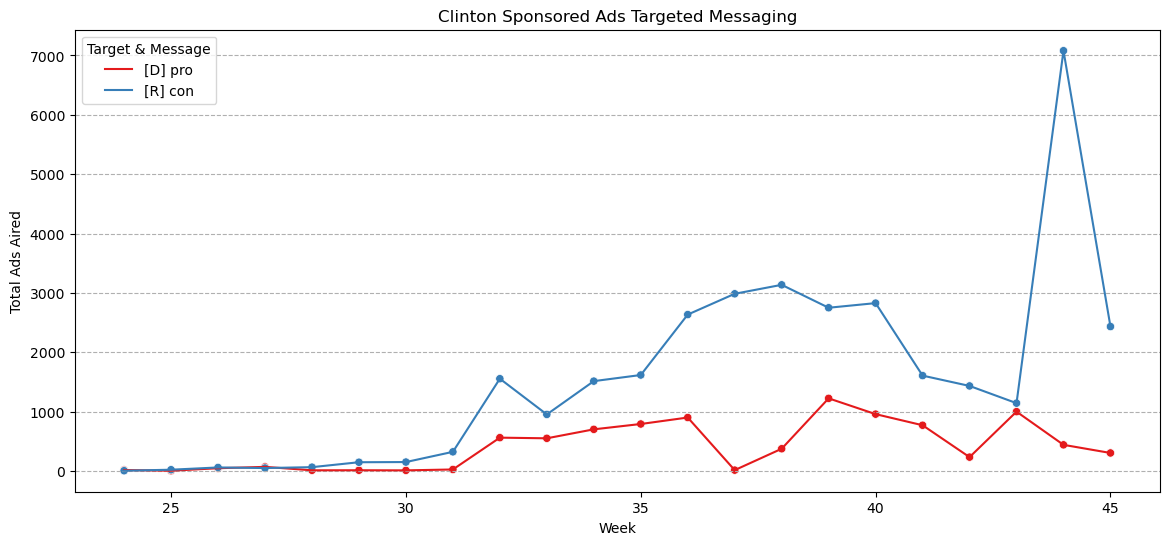

In [267]:
fig, ax = plt.subplots(figsize = (14, 6))

sns.lineplot(x = 'week', y = 'archive_id', hue = 'party_mes', data = df_plot3, ax=ax, palette = 'Set1')
sns.scatterplot(x = 'week', y = 'archive_id', hue = 'party_mes', data = df_plot3, ax=ax, palette = 'Set1', legend=False)

plt.title('Clinton Sponsored Ads Targeted Messaging')
ax.set(xlabel = 'Week', ylabel = 'Total Ads Aired')
plt.legend(title = 'Target & Message')
# plt.xticks(rotation = 90)
plt.grid(axis = 'y', linestyle = '--')
plt.show()

### Trump messaging type

In [261]:
df_plot3 = ads_tc[ads_tc.trump_sponsored].groupby(['week', 'ad_party', 'message']).agg({'archive_id':'count'}).reset_index()
df_plot3 = df_plot3[(df_plot3.week >= 24) & (df_plot3.week <= 45)]
df_plot3 = df_plot3[(df_plot3.message == 'pro') | (df_plot3.message == 'con')]
df_plot3['party_mes'] = "[" + df_plot3.ad_party + "] " + df_plot3.message

In [262]:
df_plot3.head()

,week,ad_party,message,archive_id,party_mes
57,24,D,con,150,[D] con
58,24,R,pro,1,[R] pro
59,25,D,con,48,[D] con
61,25,R,pro,5,[R] pro
62,26,D,con,64,[D] con


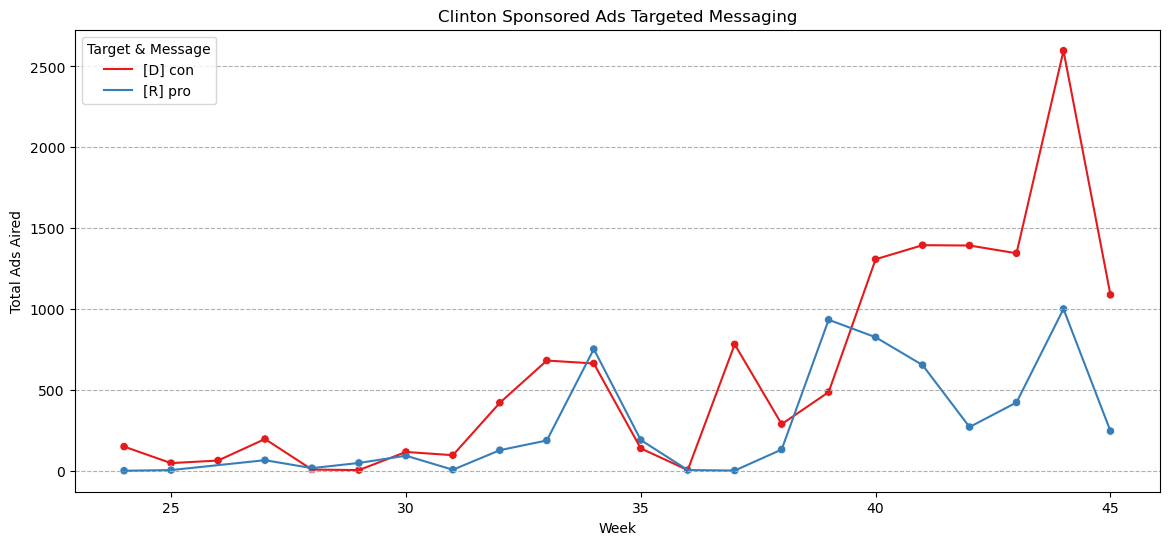

In [263]:
fig, ax = plt.subplots(figsize = (14, 6))

sns.lineplot(x = 'week', y = 'archive_id', hue = 'party_mes', data = df_plot3, ax=ax, palette = 'Set1')
sns.scatterplot(x = 'week', y = 'archive_id', hue = 'party_mes', data = df_plot3, ax=ax, palette = 'Set1', legend=False)

plt.title('Clinton Sponsored Ads Targeted Messaging')
ax.set(xlabel = 'Week', ylabel = 'Total Ads Aired')
plt.legend(title = 'Target & Message')
# plt.xticks(rotation = 90)
plt.grid(axis = 'y', linestyle = '--')
plt.show()

Both Clinton and Trump spent a large amount of ads on negative messages about the other's party
* Clinton made stronger efforts to target why the Republicans are bad
* Trump spent less ads on targeting his opponent and had a higher proportion of ads about his parties pros towards the election